In [1]:
# importing required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *
import seaborn as sns
import cartopy.crs as ccrs
import cmaps
import os
from scipy import stats
import pandas as pd
import matplotlib.cm as cm
import pylab
from shapely.geometry import Point
import functools
from geopy import distance
from sklearn.metrics.pairwise import haversine_distances

In [2]:
# Get the list of all files and directories
path1 = "./DATA/AMSR-E"
path2 = "./DATA/CloudSat"
new_list = os.listdir(path1)
new_list2 = os.listdir(path2)

In [3]:
# Creating a list of all AMSR-E datasets
amsre_list = ['./DATA/AMSR-E/' + i for i in new_list]
# Sorting datafiles by dates
amsre_list.sort()

In [4]:
# Creating a list of all CloudSat datasets
cloudsat_list = ['./DATA/CloudSat/' + i for i in new_list2]
# Sorting datafiles by dates
cloudsat_list.sort()

In [5]:
def get_amsre_data(dataset_list):
    # Initialize empty lists to store data
    lon_list = []         # List to store Longitude data
    lat_list = []         # List to store Latitude data
    amsre_89_v_list = []  
    amsre_89_h_list = []  
    amsre_36_v_list = []  
    amsre_36_h_list = []  
    
    # Iterate over each dataset in the input dataset_list
    for el in dataset_list:
        # Read data from the current dataset
        amsr_e = SD(el, SDC.READ)
        amsr_e_info = amsr_e.datasets()
        lat_amsr_e_sds = amsr_e.select('Latitude')
        lat_amsr_e = lat_amsr_e_sds.get()
        lon_amsr_e_sds = amsr_e.select('Longitude')
        lon_amsr_e = lon_amsr_e_sds.get()
        amsr_e_36v_sds = amsr_e.select('36.5V_Res.4_TB_(not-resampled)')
        amsr_e_36v_raw = amsr_e_36v_sds.get()
        amsr_e_36v_attributes = amsr_e_36v_sds.attributes()
        amsr_e_36h_sds = amsr_e.select('36.5H_Res.4_TB_(not-resampled)')
        amsr_e_36h_raw = amsr_e_36h_sds.get()
        amsr_e_36h_attributes = amsr_e_36h_sds.attributes()
        amsr_e_89v_sds = amsr_e.select('89.0V_Res.4_TB')
        amsr_e_89v_raw = amsr_e_89v_sds.get()
        amsr_e_89v_attributes = amsr_e_89v_sds.attributes()
        amsr_e_89h_sds = amsr_e.select('89.0H_Res.4_TB')
        amsr_e_89h_raw = amsr_e_89h_sds.get()
        amsr_e_89h_attributes = amsr_e_89h_sds.attributes()

        # Apply scaling and offset operations to convert raw data to physical units
        amsr_e_89v = (amsr_e_89v_raw * amsr_e_89v_attributes['SCALE FACTOR']) + amsr_e_89v_attributes['OFFSET']
        amsr_e_89h = (amsr_e_89h_raw * amsr_e_89h_attributes['SCALE FACTOR']) + amsr_e_89h_attributes['OFFSET']
        amsr_e_36v = (amsr_e_36v_raw * amsr_e_36v_attributes['SCALE FACTOR']) + amsr_e_36v_attributes['OFFSET']
        amsr_e_36h = (amsr_e_36h_raw * amsr_e_36h_attributes['SCALE FACTOR']) + amsr_e_36h_attributes['OFFSET']

        # Append processed data to respective lists
        lon_list.append(lon_amsr_e)
        lat_list.append(lat_amsr_e)
        amsre_89_v_list.append(amsr_e_89v)
        amsre_89_h_list.append(amsr_e_89h)
        amsre_36_v_list.append(amsr_e_36v)
        amsre_36_h_list.append(amsr_e_36h)

    # Concatenate lists to create arrays
    lon = np.concatenate(lon_list)
    lat = np.concatenate(lat_list)
    amsre_36_v = np.concatenate(amsre_36_v_list)
    amsre_36_h = np.concatenate(amsre_36_h_list)
    amsre_89_v = np.concatenate(amsre_89_v_list)
    amsre_89_h = np.concatenate(amsre_89_h_list)

    # Return the processed data arrays
    return lon, lat, amsre_89_v, amsre_89_h, amsre_36_v, amsre_36_h

In [6]:
def get_cloudsat_data(cloudsat_file):
    # Constants for data scaling and offset
    cs_mask_offset = 0.0
    cs_mask_factor = 1.0
    cs_mask_valid = [0, 40]     # Valid range for CPR_Cloud_mask data
    cs_ref_offset = 0.0
    cs_ref_factor = 100.0
    cs_ref_valid = [-4000, 5000]  # Valid range for Radar_Reflectivity data

    # Read data from the CloudSat file
    cs = SD(cloudsat_file, SDC.READ)
    cs_hgt_sds = cs.select('Height')
    cs_hgt = np.array(cs_hgt_sds.get())

    # Process CPR_Cloud_mask data
    cs_mask_sds = cs.select('CPR_Cloud_mask')
    cs_mask = np.array(cs_mask_sds.get(), dtype=float)
    cs_mask[(cs_mask < cs_mask_valid[0]) | (cs_mask > cs_mask_valid[1])] = np.nan
    cs_mask = (cs_mask - cs_mask_offset) / cs_mask_factor

    # Process Radar_Reflectivity data
    cs_ref_sds = cs.select('Radar_Reflectivity')
    cs_ref = np.array(cs_ref_sds.get(), dtype=float)
    cs_ref[(cs_ref < cs_ref_valid[0]) | (cs_ref > cs_ref_valid[1])] = np.nan
    cs_ref = (cs_ref - cs_ref_offset) / cs_ref_factor

    # Set Radar_Reflectivity data to NaN where CPR_Cloud_mask is between 0 and 20
    cs_ref[(cs_mask >= 0) & (cs_mask <= 20)] = np.nan

    # Read Lat/lon from another CloudSat file (not shown in the code)
    # Replace cloudsat_list[22] with the appropriate file name or path
    f = HDF(cloudsat_list[22], SDC.READ)
    vs = f.vstart()
    lat_cs = np.array(vs.attach('Latitude')[:])
    lon_cs = np.array(vs.attach('Longitude')[:])

    # Return the processed data arrays
    return lon_cs, lat_cs, cs_ref, cs_hgt

# Determine CloudSat Echo Top Height
## Echo top will be determined as a height at which reflectivity sign changes. There is a lot of missing values for reflectivity. For such cases echo top height value will be NaN.

In [7]:
def echo_top_hgt(cs_file):
    # Get CloudSat data
    lon_cs, lat_cs, cs_ref, cs_hgt = get_cloudsat_data(cs_file)
    # Transform cs_height and cs_reflectivity data into pandas DataFrames
    cpr_hgt_df = pd.DataFrame(cs_hgt).T
    cpr_hgt_df = cpr_hgt_df[cpr_hgt_df.select_dtypes(include=[np.number]).ge(0).all(1)]
    cpr_ref_df = pd.DataFrame(cs_ref).T.fillna(-20000)
    cpr_ref_df = cpr_ref_df.drop(cpr_ref_df.index[104:])

    # Define a function to locate index at which reflectivity sign changes
    def find_min_sign_changes(df):
        vals = df[col].values
        abs_sign_diff = np.abs(np.diff(np.sign(vals)))
        # idx of first row where the change is
        change_idx = np.flatnonzero(abs_sign_diff == 2)
        # +1 to get idx of second rows in the sign change too
        change_idx = np.stack((change_idx, change_idx + 1), axis=1)
        # now we have the locations where sign changes occur. We just need to extract
        # the `value` values at those locations to determine which of the two possibilities
        # to choose for each sign change (whichever has `value` closer to 0)
        min_idx = np.abs(vals[change_idx]).argmin(1)
        return df.iloc[change_idx[range(len(change_idx)), min_idx], col]

    # Get index number into a list for each column in cpr_ref_df
    empty = []
    for col in cpr_ref_df:
        empty.append(find_min_sign_changes(cpr_ref_df))

    # Combine index numbers into a series
    ser = pd.Series(empty)

    # Create a DataFrame containing the minimum reflectivity and corresponding index for each column in cpr_ref_df
    out = pd.concat([x.iloc[[0]].to_frame().unstack() if not x.empty else pd.Series({(x.name, 0): 0}) for x in ser])
    filtered_reflectivity = pd.DataFrame(out).reset_index().drop('level_0', axis=1).rename(columns={'level_1': 'index', 0: 'Reflectivity'})

    # Extract echo top heights using the index values from filtered_reflectivity
    index = filtered_reflectivity['index'].tolist()
    res = []
    for col in cpr_hgt_df:
        res.append(cpr_hgt_df[col][index[col]])

    # Create a DataFrame containing the echo top heights and corresponding reflectivity values
    echo_top_height = pd.DataFrame(res)
    echo_top_height['Reflectivity'] = filtered_reflectivity['Reflectivity']
    echo_top_height.rename(columns={0: 'Echo_top_height'}, inplace=True)
    return echo_top_height

In [8]:
# Using list comprehension to get echo top height data for each cloudsat file
list_of_echo_df = [echo_top_hgt(f) for f in cloudsat_list]

# Match CloudSat and AMSR-E

In [9]:
from sklearn.neighbors import BallTree
from sklearn.metrics import DistanceMetric
def amsre_cs(cs_file, amsre_list):
    # Get CloudSat data: Longitude, Latitude, Reflectivity, and Height
    lon_cs, lat_cs, cs_ref, cs_hgt = get_cloudsat_data(cs_file)

    # Get AMSR-E data: Longitude, Latitude, TBV89, TBH89, TBV36, TBH36
    lon, lat, amsre_89_v, amsre_89_h, amsre_36_v, amsre_36_h = get_amsre_data(amsre_list)

    # Convert data to pandas DataFrames
    cloudsat_lat_df = pd.DataFrame(lat_cs)
    cloudsat_lon_df = pd.DataFrame(lon_cs)
    amsre_lat_df = pd.DataFrame(lat) 
    amsre_lon_df = pd.DataFrame(lon)
    tbv_89 = pd.DataFrame(amsre_89_v)
    tbh_89 = pd.DataFrame(amsre_89_h)
    tbv_36 = pd.DataFrame(amsre_36_v)
    tbh_36 = pd.DataFrame(amsre_36_h)

    # Rename columns of DataFrames for better readability
    cloudsat_lon_df.rename(columns={0: 'Longitude'}, inplace=True)
    cloudsat_lat_df.rename(columns={0: 'Latitude'}, inplace=True)

    # Concatenate Longitude and Latitude DataFrames for CloudSat
    cloudsat_mix = pd.concat([cloudsat_lon_df, cloudsat_lat_df], axis=1)

    # Stack and rename columns of AMSR-E DataFrames for better readability
    lo = pd.DataFrame(amsre_lon_df.stack())
    lo.rename(columns={0: 'Longitude'}, inplace=True)
    la = pd.DataFrame(amsre_lat_df.stack())
    la.rename(columns={0: 'Latitude'}, inplace=True)
    bt89v = pd.DataFrame(tbv_89.stack())
    bt89v.rename(columns={0: 'TBV89'}, inplace=True)
    bt89h = pd.DataFrame(tbh_89.stack())
    bt89h.rename(columns={0: 'TBH89'}, inplace=True)
    bt36v = pd.DataFrame(tbv_36.stack())
    bt36v.rename(columns={0: 'TBV36'}, inplace=True)
    bt36h = pd.DataFrame(tbh_36.stack())
    bt36h.rename(columns={0: 'TBH36'}, inplace=True)

    # Concatenate AMSR-E DataFrames to create the feature DataFrame 'f'
    f = pd.concat([lo, la, bt89v, bt89h, bt36v, bt36h], axis=1)

    # Convert Latitude and Longitude coordinates to radians for distance calculation
    coords = np.radians(f[['Latitude', 'Longitude']])
    dist = DistanceMetric.get_metric('haversine')

    # Build BallTree using AMSR-E coordinates
    tree = BallTree(coords, metric=dist)

    # Convert Latitude and Longitude coordinates of CloudSat to radians
    coords = np.radians(cloudsat_mix[['Latitude', 'Longitude']])

    # Query BallTree to find nearest neighbors (k=1) for CloudSat coordinates
    distances, indices = tree.query(coords, k=1)

    # Retrieve TBV89, TBV36, TBH89, and TBH36 values from the AMSR-E feature DataFrame
    # based on the nearest neighbors' indices and assign them to CloudSat DataFrame
    cloudsat_mix['TBV89'] = f['TBV89'].iloc[indices.flatten()].values
    cloudsat_mix['TBV36'] = f['TBV36'].iloc[indices.flatten()].values
    cloudsat_mix['TBH89'] = f['TBH89'].iloc[indices.flatten()].values
    cloudsat_mix['TBH36'] = f['TBH36'].iloc[indices.flatten()].values

    # Assign distances to CloudSat DataFrame
    cloudsat_mix['Distance'] = distances.flatten()

    # Return the final DataFrame containing CloudSat and AMSR-E data
    return cloudsat_mix

In [10]:
# Dividing amsre data into chunks of 3 because each cloudsat datafile covers 3 amsr-e datafiles
chunks = [amsre_list[x:x+3] for x in range(0, len(amsre_list), 3)]

In [11]:
# Create a list of DataFrames using list comprehension
list_of_cs_df = [amsre_cs(i, j) for (i, j) in zip(cloudsat_list, chunks)]

In [12]:
# Create final_list of echo top data and amsre data using list comprehension
final_list = [i.join(j) for (i, j) in zip(list_of_cs_df, list_of_echo_df)]

In [39]:
# Concatenate a list of DataFrames into a single DataFrame
final = pd.concat(final_list)

In [40]:
# Reset the index of the DataFrame and drop the previous index
final.reset_index(drop=True, inplace=True)

In [41]:
final.head()

,Longitude,Latitude,TBV89,TBV36,TBH89,TBH36,Distance,Echo_top_height,Reflectivity
0,159.823303,-0.007365,0.0,267.459994,0.0,262.239994,1.150422,273.0,27.90
1,159.821259,-0.017034,0.0,267.459994,0.0,262.239994,1.150502,274.0,29.34
2,159.819199,-0.026703,0.0,267.459994,0.0,262.239994,1.150582,276.0,29.40
3,159.817154,-0.036372,0.0,267.459994,0.0,262.239994,1.150662,24979.0,0.00
4,159.815094,-0.046041,0.0,267.459994,0.0,262.239994,1.150742,24981.0,0.00


In [42]:
# Use query() method to filter the DataFrame 
final = final.query('(Reflectivity != 0.0) & (TBV89 != 0.0) & (TBV36 != 0.0) & (TBH89 != 0.0) & (TBH36 != 0.0)').reset_index(drop=True)

In [43]:
# Select only the datapoints from AMSR-E and CloudSat that are in close proximity to one another
final = final[final['Distance'] <= 0.0007847199224249245]

In [44]:
# Drop all missing values and reset index
final = final.dropna().reset_index(drop=True)

/var/folders/9g/vy_4_9x1485_v_ltw5ybg00r0000gq/T/ipykernel_86086/3805936440.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  final.drop(columns = ['Longitude','Latitude']).hist(ax=ax, bins=20, edgecolor='black', grid=False)


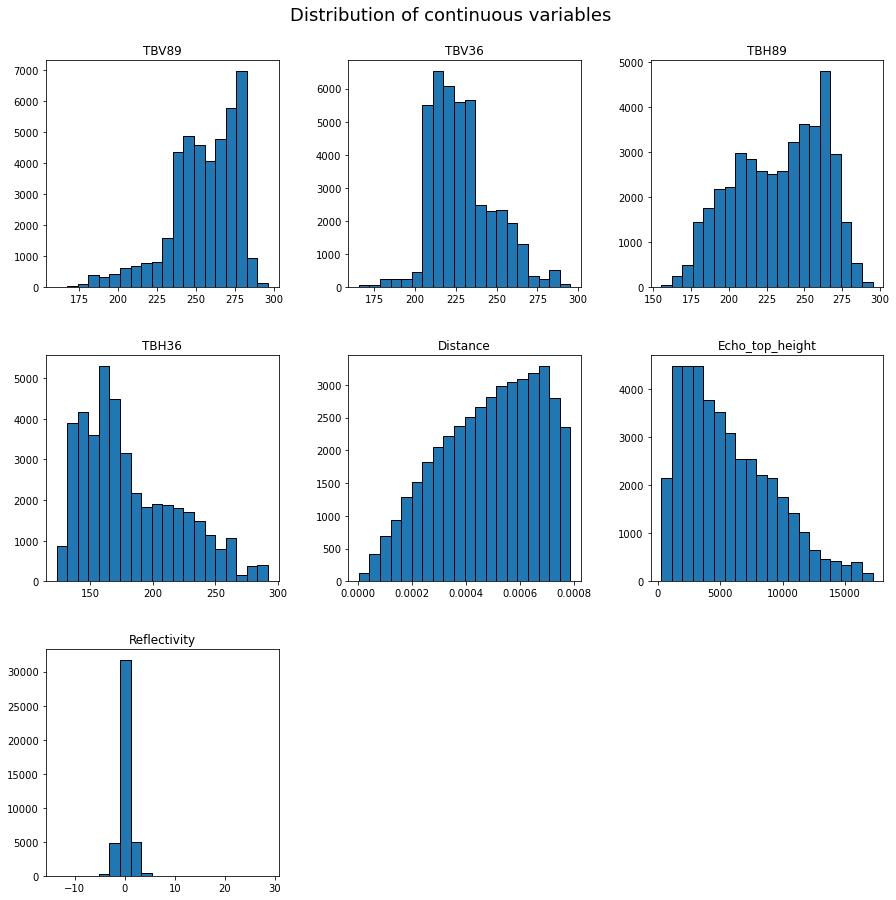

In [45]:
# Create a new figure and set its size
fig = plt.figure(figsize=(15, 15))

# Get the current Axes of the figure
ax = fig.gca()

# Plot histograms for each column in the DataFrame 'final'
final.drop(columns = ['Longitude','Latitude']).hist(ax=ax, bins=20, edgecolor='black', grid=False)

# Add titles, labels, and adjust plot appearance
plt.suptitle('Distribution of continuous variables', fontsize=18,y=0.93)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Values', fontsize=14)

# Remove unnecessary spines (top and right) for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

In [46]:
# Calculate the correlation matrix for the DataFrame 'final'
# Drop the columns 'Longitude' and 'Latitude' before calculating the correlation
corrMatrix = final.drop(columns=['Longitude', 'Latitude']).corr()

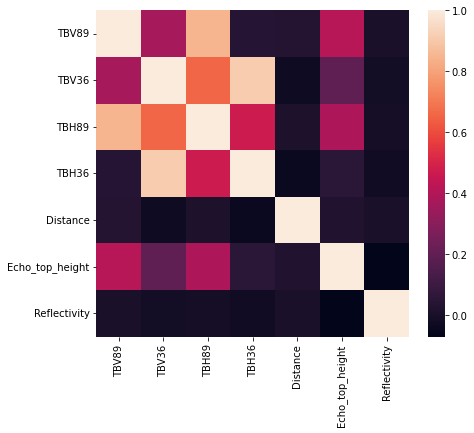

In [48]:
# Create a new figure and set its size
fig = plt.figure(figsize=(7, 6))
sns.heatmap(corrMatrix)
plt.show()

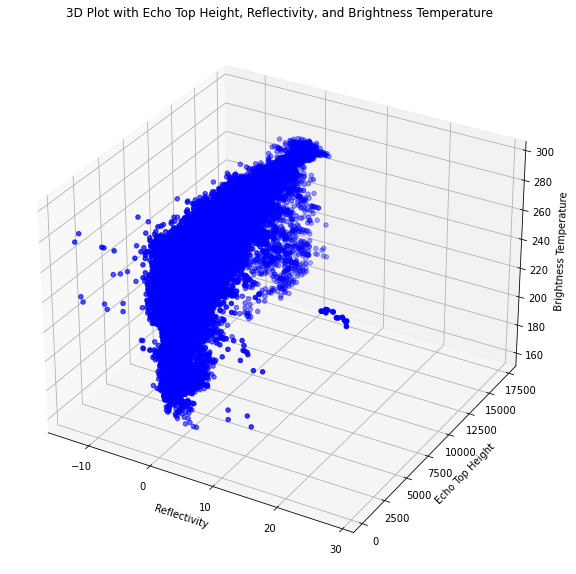

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data (replace with your actual data)
height_data = final['Echo_top_height']  # Height data
reflectivity_data = final['Reflectivity']      # Reflectivity data
temperature_data = final['TBV89']       # Temperature data

# Create a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(reflectivity_data, height_data, temperature_data, c='b', marker='o')

# Set labels and title
ax.set_xlabel('Reflectivity')
ax.set_ylabel('Echo Top Height')
ax.set_zlabel('Brightness Temperature')
ax.set_title('3D Plot with Echo Top Height, Reflectivity, and Brightness Temperature')

# Show the plot
plt.show()

In [50]:
# Save the dataframe as csv file
final.to_csv('filtered_df.csv')